# Lab 5: Choice Algorithm
11/15/2024 - Adam Haile, Aiden Miller, Leigh Goetsch, Class: CSC3310

In [3]:
import math
import random
from typing import Any, List

In [4]:
class Node():
    def __init__(self, value: Any, parent: 'Node' = None, left: 'Node' = None, right: 'Node' = None):
        self.value = value
        self.parent = parent
        self.left = left
        self.right = right

In [5]:
import math
from typing import Any, List

class Node():
    def __init__(self, value: Any, left: 'Node' = None, right: 'Node' = None):
        self.value = value
        self.left = left
        self.right = right

class SGTree():
    def __init__(self, alpha=(3 / 4)):
        self.root = None
        self.alpha = alpha  # Balancing factor
        self.tree_size = 0  # Current size of the tree
        self.max_size = 0  # Maximum size of the tree before shrinkage
        self.rebuild_counter = 0  # Counter for rebuild operations

    def insert(self, value: Any) -> None:
        if not self.root:
            self.root = Node(value)
            self.tree_size = 1
            self.max_size = 1
            return

        path = []
        node = self.root
        while node:
            path.append(node)
            if value < node.value:
                if node.left is None:
                    node.left = Node(value)
                    break
                node = node.left
            elif value > node.value:
                if node.right is None:
                    node.right = Node(value)
                    break
                node = node.right
            else:
                return  # Key already exists, do nothing

        self.tree_size += 1
        self.max_size = max(self.max_size, self.tree_size)

        for i in range(len(path)):
            node = path[-(i + 1)]
            if not self.is_balanced(node):
                self.rebuild(path[-(i + 2)] if i + 2 <= len(path) else None, node)
                break

    def is_balanced(self, node: Node) -> bool:
        size_left = self.subtree_size(node.left)
        size_right = self.subtree_size(node.right)
        return size_left <= self.alpha * self.subtree_size(node) and size_right <= self.alpha * self.subtree_size(node)

    def subtree_size(self, node: Node) -> int:
        if not node:
            return 0
        return 1 + self.subtree_size(node.left) + self.subtree_size(node.right)

    def rebuild(self, parent: Node, node: Node) -> None:
        self.rebuild_counter += 1
        nodes = self.flatten(node)
        new_subtree = self.build_balanced(nodes)

        if not parent:
            self.root = new_subtree
        elif parent.left == node:
            parent.left = new_subtree
        else:
            parent.right = new_subtree

    def flatten(self, node: Node) -> List[Node]:
        nodes = []
        self._inorder_traversal(node, nodes)
        return nodes

    def _inorder_traversal(self, node: Node, nodes: List[Node]) -> None:
        if not node:
            return
        self._inorder_traversal(node.left, nodes)
        nodes.append(node)
        self._inorder_traversal(node.right, nodes)

    def build_balanced(self, nodes: List[Node]) -> Node:
        if not nodes:
            return None
        mid = len(nodes) // 2
        root = nodes[mid]
        root.left = self.build_balanced(nodes[:mid])
        root.right = self.build_balanced(nodes[mid + 1:])
        return root
    
    def size(self) -> int: 
        return self.tree_size

    def contains(self, value: Any) -> bool:
        node = self.root
        while node:
            if value < node.value:
                node = node.left
            elif value > node.value:
                node = node.right
            else:
                return True
        return False

    def _delete(self, node: Node, value: Any) -> Node:
            if not node:
                return None
            if value < node.value:
                node.left = self._delete(node.left, value)
            elif value > node.value:
                node.right = self._delete(node.right, value)
            else:
                if not node.left:
                    return node.right
                if not node.right:
                    return node.left

                successor = node.right
                while successor.left:
                    successor = successor.left

                node.value = successor.value
                node.right = self._delete(node.right, successor.value)

            return node

    def delete(self, value: Any) -> None:
        if self.contains(value):
            self.root = self._delete(self.root, value)
            self.tree_size -= 1

        if self.tree_size < self.alpha * self.max_size:
            self.root = self.build_balanced(self.flatten(self.root))
            self.max_size = self.tree_size
            self.rebuild_counter += 1

    def to_list(self)-> List[Any]:
        result: List[Node] = []
        self._inorder_traversal(self.root, result)
        return [node.value for node in result]

In [6]:
values = random.sample(range(1, 101), 10)
values

[12, 79, 77, 50, 18, 54, 39, 81, 34, 84]

In [7]:
tree = SGTree()
for value in values:
    tree.insert(value)
    print(tree.to_list())

for value in random.sample(values, 10):
    tree.delete(value)
    print(tree.to_list())

[12]
[12, 79]
[12, 77, 79]
[12, 50, 77, 79]
[12, 18, 50, 77, 79]
[12, 18, 50, 54, 77, 79]
[12, 18, 39, 50, 54, 77, 79]
[12, 18, 39, 50, 54, 77, 79, 81]
[12, 18, 34, 39, 50, 54, 77, 79, 81]
[12, 18, 34, 39, 50, 54, 77, 79, 81, 84]
[18, 34, 39, 50, 54, 77, 79, 81, 84]
[18, 39, 50, 54, 77, 79, 81, 84]
[18, 39, 50, 54, 77, 81, 84]
[18, 39, 50, 54, 77, 84]
[18, 50, 54, 77, 84]
[18, 50, 77, 84]
[18, 77, 84]
[18, 77]
[18]
[]


## Tests

In [9]:
# assert that the tree stays sorted
values = random.sample(range(1, 101), 20)

def test_tree_sorted(values: List[int]):
    tree = SGTree()
    lst = []
    for value in values:
        tree.insert(value)
        lst.append(value)
        lst.sort()
        assert tree.to_list() == lst

In [10]:
test_tree_sorted(values)
test_tree_sorted(sorted(values, reverse=True))
test_tree_sorted(sorted(values))

In [31]:
import unittest

class TestSGtree(unittest.TestCase):
    
    def setUp(self):
        self.tree = SGTree()
    
    def test_empty_tree(self):
        self.assertIsNone(self.tree.root)
    
    def test_single_node(self):
        self.tree.insert(10)
        self.assertEqual(self.tree.root.value, 10)
    
    def test_balanced_tree(self):
        values = [10, 5, 15, 3, 7, 13, 17]
        for value in values:
            self.tree.insert(value)
        self.assertTrue(self.tree.is_balanced(tree.root))
    
    def test_insertion(self):
        self.tree.insert(10)
        self.tree.insert(5)
        self.tree.insert(15)
        self.assertEqual(self.tree.root.value, 10)
        self.assertEqual(self.tree.root.left.value, 5)
        self.assertEqual(self.tree.root.right.value, 15)
    
    def test_deletion(self):
        values = [10, 5, 15, 3, 7, 13, 17]
        for value in values:
            self.tree.insert(value)
        for value in values:
            self.tree.delete(value)
            self.assertFalse(self.tree.contains(value))
    
    def test_traversal(self):
        values = [10, 5, 15, 3, 7, 13, 17]
        for value in values:
            self.tree.insert(value)
        self.assertEqual(self.tree.to_list(), [3, 5, 7, 10, 13, 15, 17])

In [32]:
tester = TestSGtree()
tester.setUp()
tester.test_empty_tree()
tester.test_single_node()
tester.test_balanced_tree()
tester.test_insertion()
tester.test_deletion()
tester.test_traversal()

## Benchmarks
Benchmark the insert, delete, and contains operations of your implementation on data sets of
different sizes. Create tables and plots that include both run times and the number of times the
rebuild operation was performed.

In [ ]:
import random
import time
import pandas as pd

results = []
sizes = [5 ** i for i in range(1, 6)]
input_types = ["Random", "Sorted", "Reverse-Sorted"]

for size in sizes:
    for input_type in input_types:
        if input_type == "Random":
            values = random.sample(range(size * 10), size)
        elif input_type == "Sorted":
            values = list(range(size))
        elif input_type == "Reverse-Sorted":
            values = list(range(size, 0, -1))

        tree = SGTree()

        # Insertion
        start_time = time.time()
        for val in values:
            tree.insert(val)
        insertion_time = time.time() - start_time

        # Contains (search)
        start_time = time.time()
        for val in values:
            tree.contains(val)
        contains_time = time.time() - start_time

        # Deletion
        start_time = time.time()
        for val in values:
            tree.delete(val)
        deletion_time = time.time() - start_time

        results.append({
            "Size": size,
            "Input Type": input_type,
            "Insertion Time (s)": insertion_time,
            "Contains Time (s)": contains_time,
            "Deletion Time (s)": deletion_time,
        })

df = pd.DataFrame(results)

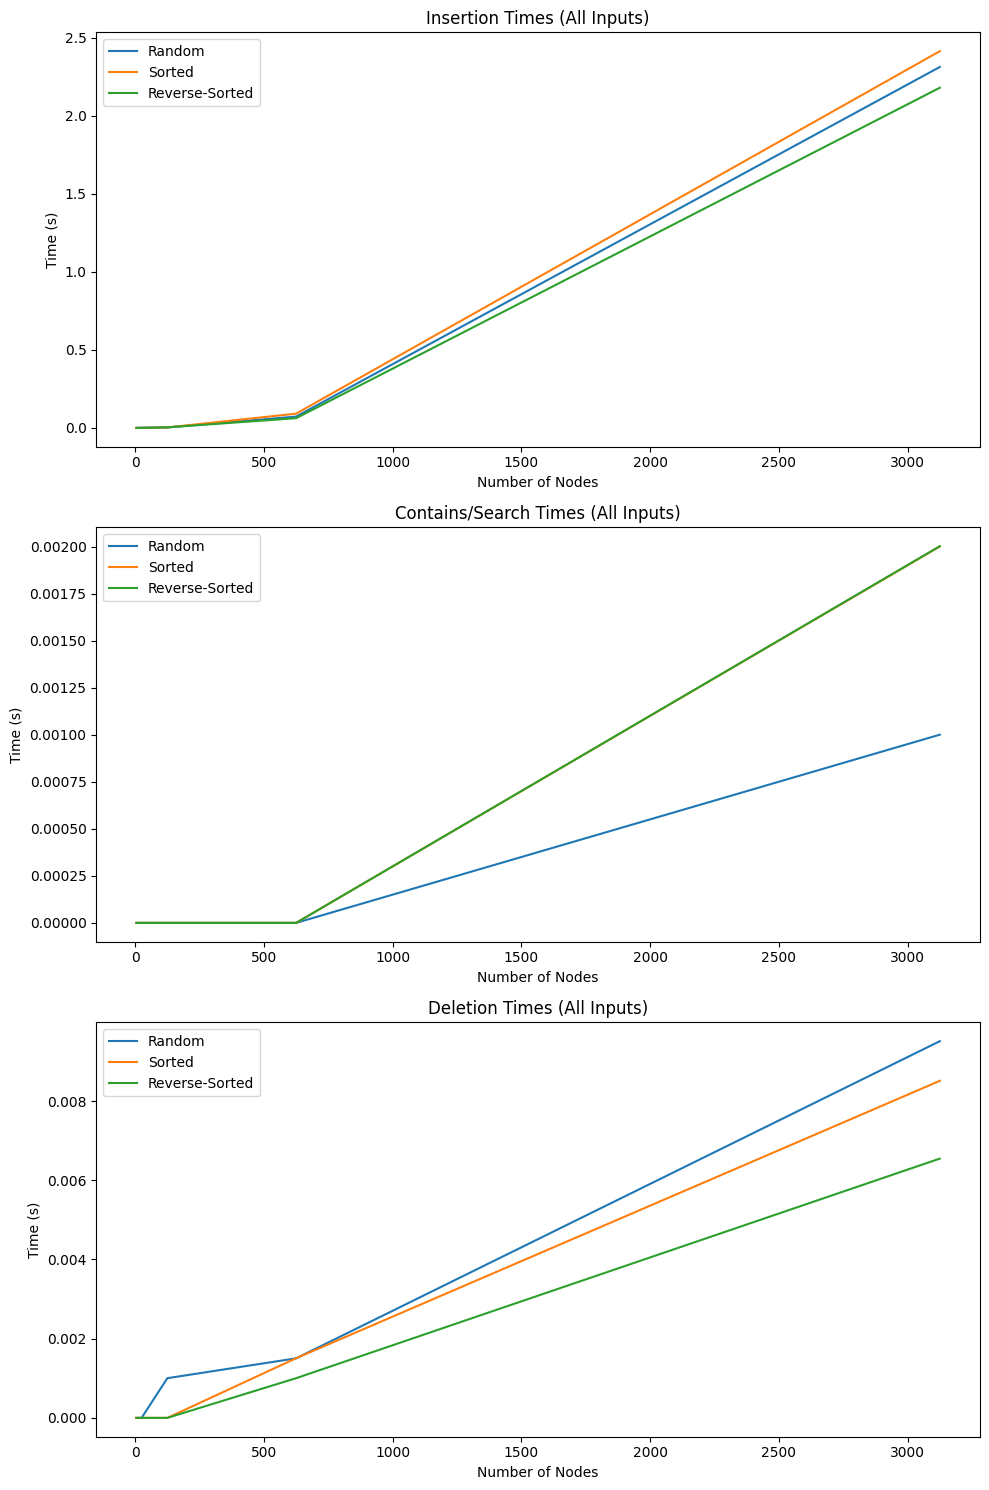

In [58]:
import matplotlib.pyplot as plt

operations = ["Insertion Time (s)", "Contains Time (s)", "Deletion Time (s)"]
titles = ["Insertion", "Contains/Search", "Deletion"]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
input_types = df["Input Type"].unique()

for i, operation in enumerate(operations):
    for input_type in input_types:
        subset = df[df["Input Type"] == input_type]
        ax[i].plot(subset["Size"], subset[operation], label=f"{input_type}")
    ax[i].set_title(f"{titles[i]} Times (All Inputs)")
    ax[i].set_xlabel("Number of Nodes")
    ax[i].set_ylabel("Time (s)")
    ax[i].legend()

plt.tight_layout()
plt.show()